# Quantum Machine Learning and Quantum Support Vector Classifier (QSVC)

## Required Libraries

1. Pennylane - for quantum circuit simulations
2. scikit-learn - for Machine Learning

`Uncomment the code cell below to instal the two libraries`

In [8]:
# !pip install pennylane==0.37
# !pip install scikit-learn==1.5.1

## Introduction to Machine Learning

Machine learning is a subset of artificial intelligence (AI) focused on building systems that learn from data and improve their performance over time without being explicitly programmed. It involves algorithms that can recognize patterns, make decisions, and predict outcomes based on input data.

### Key Concepts

1. **Data**: The foundation of machine learning. Data is often split into training sets (to teach the model) and testing sets (to evaluate the model's performance).
   
2. **Algorithms**: Procedures or methods for solving a problem. Common machine learning algorithms include Support Vector Machines, linear regression, decision trees, and neural networks.
   
3. **Models**: The output of the learning process. Models represent patterns learned from the training data and are used to make predictions or decisions.

4. **Training**: The process of feeding data into the algorithm to help it learn. During training, the model adjusts its parameters to minimize errors.

5. **Evaluation**: Assessing the model's performance using metrics like accuracy, precision, recall, and F1-score.

### Types of Machine Learning

1. **Supervised Learning**: The model is trained on labeled data, meaning the input comes with corresponding output. Examples include classification and regression tasks.
   
2. **Unsupervised Learning**: The model is trained on unlabeled data and must find patterns and relationships in the data. Examples include clustering and association tasks.


## Classification and Support Vector Machines (SVMs)

### Classification

Classification is a type of supervised learning in machine learning where the goal is to categorize input data into predefined classes or labels. Given a dataset with known labels, a classification algorithm learns to assign labels to new, unseen data based on the patterns it has learned during training.

#### Common Applications
- **Spam Detection**: Classifying emails as spam or non-spam.
- **Image Recognition**: Identifying objects within images, such as distinguishing between cats and dogs.
- **Medical Diagnosis**: Classifying medical images or patient data into disease categories.

### Support Vector Machines (SVMs)

Support Vector Machines (SVMs) are powerful and versatile supervised learning models used for classification and regression tasks. They are particularly effective in high-dimensional spaces and are known for their robustness in handling both linear and non-linear data.

#### Key Concepts

1. **Hyperplane**: In SVMs, the algorithm tries to find the optimal hyperplane that best separates the data into different classes. For a two-dimensional space, this hyperplane is a line; for higher dimensions, it is a flat affine subspace.

2. **Support Vectors**: The data points that are closest to the hyperplane. These points are crucial in defining the position and orientation of the hyperplane.

3. **Margin**: The distance between the hyperplane and the nearest support vectors from any class. SVM aims to maximize this margin to ensure the best separation between classes.

4. **Kernel Trick**: SVMs can efficiently perform a non-linear classification using the kernel trick, implicitly mapping input features into high-dimensional feature spaces. Common kernels include linear, polynomial, and radial basis function (RBF) kernels.

#### Advantages of SVMs
- Effective in high-dimensional spaces.
- Works well with a clear margin of separation.
- Robust against overfitting, especially in high-dimensional space.

#### Applications of SVMs
- **Text Categorization**: Sorting documents into categories based on content.
- **Bioinformatics**: Classifying proteins or gene expression data.
- **Image Classification**: Identifying objects within images.

### Quantum Support Vector Classification (QSVC)

QSVC is a variant of the traditional Support Vector Machine (SVM) that leverages quantum computing principles to enhance performance. It is part of the emerging field of Quantum Machine Learning, which seeks to utilize quantum algorithms to solve complex machine learning problems more efficiently than classical approaches.


In [ ]:
# Importing Required Libraries
import time

import numpy as np
import matplotlib.pyplot as plt

# scikit-learn
import sklearn
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import pennylane as qml
from pennylane.templates import AngleEmbedding

np.random.seed(42)

print(f'Pennylane version: {qml.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

## Dataset 
Loading the [Iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [3]:
X, y = load_iris(return_X_y=True)
print(f'Shape of data: {X.shape, y.shape}')

Shape of data: ((150, 4), (150,))


In [11]:
# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# # scaling the labels to -1, 1 is important for the SVM and the
# # definition of a hinge loss
y_scaled = 2 * (y - 0.5)

# y_scaled = y

Training set shape: (80, 4)
Testing set shape: (20, 4)


In [ ]:

# Splitting the data in to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2,random_state=42)

# scaling the inputs is important since the embedding we use is periodic
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

In [12]:
n_qubits = X.shape[1]
dev= qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev, interface="autograd")
def inner_product(x1, x2):
    """The quantum kernel."""

    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))

    # for qubit in range(n_qubits):
    #     qml.RX(phi=x1[qubit],wires=qubit)
    #     qml.RX(phi=-1*x2[qubit],wires=qubit)

    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [13]:
# @qml.qnode(dev, interface="autograd")
# def inner_product(x1, x2):
#     """The quantum kernel."""

#     AngleEmbedding(x1, wires=range(n_qubits))
#     qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))

#     return qml.state()

# inner_product(X[1],X[2])[0]**2

In [14]:
def quantum_kernel(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    n = A.shape[0]
    m = B.shape[0]
    
    if n == m:
        gram_matrix = np.diag(np.full(n,1))
        for row in range(n):
            for col in range(m):
                if row < col:
                    gram_matrix[row, col] = inner_product(A[row], B[col])
        
        gram_matrix = gram_matrix + gram_matrix.T
        
        return gram_matrix
    else:
        return np.array([[inner_product(a, b) for b in B] for a in A])

# def quantum_kernel(A, B):
#     """Compute the matrix whose entries are the kernel
#        evaluated on pairwise data from sets A and B."""
#     return np.array([[inner_product(a, b) for b in B] for a in A])

In [18]:
start = time.time()

# Defining SVC 
qsvc = SVC(kernel=quantum_kernel)

# Fitting the clssifier
qsvc.fit(X_train, y_train)

# Making predictions on the Test set
predictions = qsvc.predict(X_test)

# Calculating the results
print(f'Classification report:\n {classification_report(y_test, predictions,digits=3)}')

print(f'Time taken to train and test: {time.time() - start}')

Classification report:
               precision    recall  f1-score   support

        -1.0      1.000     1.000     1.000        12
         1.0      1.000     1.000     1.000         8

    accuracy                          1.000        20
   macro avg      1.000     1.000     1.000        20
weighted avg      1.000     1.000     1.000        20

Time taken to train and test: 6.845061302185059


In [16]:
@qml.qnode(dev)
def pny_state(x):
    angle = np.pi/4
    for para in range(n_qubits):
        qml.RX(phi=angle*x[para],wires=para)
    return qml.state()

def pny_feature_state(rows):
    psi = np.array([])
    for i in range(rows.shape[1]):
        sv = pny_state(rows[:,i])
        psi = np.append(psi, sv)
    psi = np.reshape(psi, (rows.shape[1], 2**n_qubits))
    return psi

Time Taken: 0.1045525074005127
              precision    recall  f1-score   support

        -1.0      1.000     1.000     1.000        12
         1.0      1.000     1.000     1.000         8

    accuracy                          1.000        20
   macro avg      1.000     1.000     1.000        20
weighted avg      1.000     1.000     1.000        20



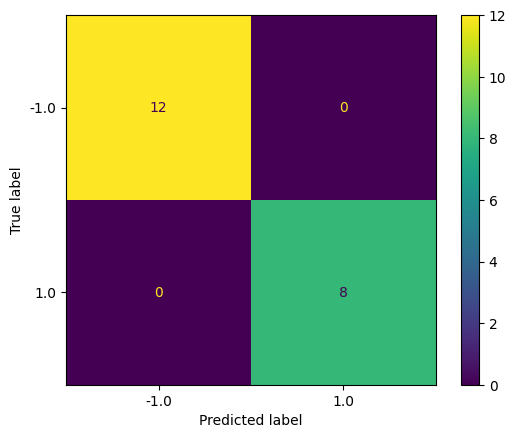

In [19]:
qsvc = SVC(kernel='precomputed')

start = time.time()

psi_train = pny_feature_state(X_train.T)
psi_test = pny_feature_state(X_test.T)

gram_train = psi_train.real @ psi_train.real.T + psi_train.imag @ psi_train.imag.T
gram_test = psi_test.real @ psi_train.real.T + psi_test.imag @ psi_train.imag.T

qsvc.fit(gram_train,y_train)

Ypred = qsvc.predict(gram_test)

ConfusionMatrixDisplay.from_predictions(y_test, Ypred)  

test_metrics = classification_report(y_test, Ypred, zero_division=0,digits=3)

print(f'Time Taken: {time.time() - start}')
print(test_metrics)

## Kernel Matrix

In [17]:
def n_cir(test_size:float ,data_points:int):

    n_train = round(data_points * (1 - test_size))
    n_test = data_points - n_train

    train_circuits = round(n_train * (n_train - 1) * 0.5)
    test_circuits = n_test * n_train

    # print(f'Train Circuits: {train_circuits:,}')
    # print(f'Test Circuits: {test_circuits:,}')

    return train_circuits+test_circuits

print(f'Circuits that need to be simulated to calcute the Kernel Matrix for training and testing: {n_cir(0.3,1000):,}')

Circuits that need to be simulated to calcute the Kernel Matrix for training and testing: 454,650


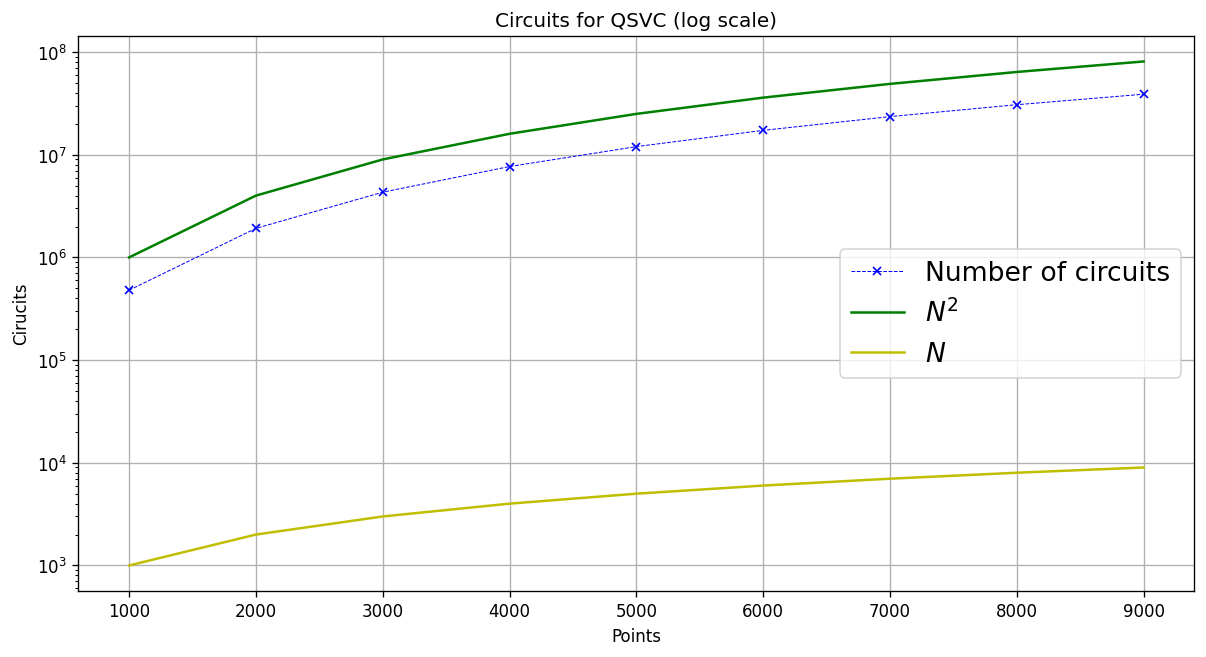

In [63]:
points = np.array([10*i for i in range(100,100*10,100)])
circs = np.array([n_cir(0.2,point) for point in points])

plt.figure(figsize=(12,6),dpi=120)

plt.plot(points,circs,ls='--',lw=0.6,marker='x',ms=5,label='Number of circuits',c='b')
plt.plot(points,points**2,label='$N^2$',c='g')
plt.plot(points,points,label='$N$',c='y')

plt.yscale('log')

plt.xlabel("Points")
plt.ylabel("Cirucits")

plt.legend(loc='right',fontsize=16)
plt.title('Circuits for QSVC (log scale)')

plt.grid()

plt.show()

## References

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209–212 (2019).